In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# for logistic sigmoid function (a.ka. expit)
# import of sigmoid and crossentropy
from scipy.special import expit
from sklearn.metrics import log_loss
from keras.datasets import mnist
from keras.utils.np_utils import to_categorical
# np.random.seed(1234)
%matplotlib inline
import sys

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
print('number of samples: {}'.format(len(iris.data)))

number of samples: 150


In [ ]:
# access the data and split into helper arrays.
x1 = iris.data
y1 = iris.target

# The samples are ordered by target class # in the original dataset.
# As a first step, we shuffle the order before splitting the data into
# training and test data
perm = np.random.permutation(x1.shape[0])
y2 = y1[perm]
x2 = x1[perm,:]

# now we take 90% of the data for trainig and 10% for testing
frac_train = 0.9
train_index = int(round(len(iris.data)*frac_train))
X_train = x2[0:train_index]
X_test  = x2[train_index+1:]

y_train = y2[0:train_index]
y_test  = y2[train_index+1:]

# convert the class number into one-hot encoding.
# e.g. target class 2 -> [0,0,1]
n_classes = 3
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)

In [ ]:
# Forward pass: calculate network response
# N.B. need to append as many components to the bias b1 and b2
#      as we have elements in each training batch using np.tile
def forward_pass(W1, W2, b1, b2, x):
  # Input to hidden layer
  a1 = np.matmul(W1,x) + np.tile(b1, x.shape[1])  # 100 x 32 (100 variations of weights times 32 solutions per sample)
  h1 = np.tanh(a1)  # activation function, hyperbolic tangent element-wise [-1,1]

  # Hidden to outpt layer
  a2 = np.matmul(W2, h1) + np.tile(b2, x.shape[1]) # 3 x 100 * 100 x 32 = 3 x 32 (3 solutions per 32 samples) - returns predictions

  # Output layer has sigmoid activation
  y_hat = expit(a2)  # activation function [0, 1]

  return a1, h1, a2, y_hat

# Backward pass: calculate changes to weights
def backward_pass_backprop(e, h1, W2, a1, x):
  dW2 = -np.matmul(e, np.transpose(h1))
  da1 =  np.matmul(np.transpose(W2),e)*(1-np.tanh(a1)**2)
  dW1 = -np.matmul(da1, np.transpose(x))

  # Change in bias b1 and b2:
  db2 = -np.sum(e, axis=1)
  db1 = -np.sum(da1, axis=1)

  return dW1, dW2, db1[:, np.newaxis], db2[:,np.newaxis]

def xavier_initialization(shape):
  fan_in, fan_out = shape
  limit = np.sqrt(6 / (fan_in + fan_out))
  return np.random.uniform(-limit, limit, size=shape)

In [ ]:
# Network parameters
n_input  = 4  # number of input neurons (4 features)
n_hidden = 100 # number of neurons in the hidden layer
n_output = n_classes  # number of neurons in the output layer - number of classes

batch_size = 32
learn_rate = 1e-4
n_epochs   = 100

# we need to change the shape of the data from a long array
# with four variables per observation to an array with the four
# input variables, each with the observations (per variable)
# and accordingly for the output for the calculations of the weights.
x = np.transpose(X_train)  # 4 x 135
y = np.transpose(y_train)  # 3 x 135

# Initialize network weights
W1 = np.random.standard_normal(size=(n_hidden, n_input))  # 100 x 4
W2 = np.random.standard_normal(size=(n_output, n_hidden))  # 3 x 100
b1 = np.random.standard_normal(size=(n_hidden, 1))
b2 = np.random.standard_normal(size=(n_output, 1))

# W1 = np.random.standard_normal(size=(n_hidden, n_input), mu=0, sigma=np.sqrt(2/4))  # 100 x 4
# W2 = np.random.standard_normal(size=(n_output, n_hidden), mu=0, sigma=np.sqrt(2/100))  # 3 x 100
# b1 = np.random.standard_normal(size=(n_hidden, 1), mu=0, sigma=np.sqrt(2/100))
# b2 = np.random.standard_normal(size=(n_output, 1), mu=0, sigma=np.sqrt(2/3))

# W1 = xavier_initialization((n_hidden, n_input))
# W2 = xavier_initialization((n_output, n_hidden))
# b1 = xavier_initialization((n_hidden, 1))
# b2 = xavier_initialization((n_output, 1))

dataset_size = x.shape[1]
n_batches = dataset_size//batch_size
print('Dataset size: {}, batch_size: {}, number of batches {}'.format(dataset_size, batch_size, n_batches))

# save the total error for each epoch, summed over all batches
train_error_epoch = []



for i in range(n_epochs):
  # Shuffle training data
  perm = np.random.permutation(x.shape[1])
  x = x[:, perm]
  y = y[:, perm]

  # Value of loss function and training error
  loss = 0.0
  train_error = 0.0

  # Loop over batches
  for j in range(n_batches):
    train_data = x[:, j*batch_size:(j+1)*batch_size]  # 4 x 32
    targets = y[:, j*batch_size:(j+1)*batch_size]  # 3 x 32

    # Forward pass
    a1, h1, a2, y_hat = forward_pass(W1=W1, W2=W2, b1=b1, b2=b2, x=train_data)

    # Metrics
    error = y_hat - targets

    # Due to one-hot encoding, each prediction and true label is an array, recover the class number via np.argmax
    preds = np.argmax(y_hat, axis=0)
    truth = np.argmax(targets, axis=0)

    # Error is the difference between prediction and true, summed over all elements in the batch
    train_error += np.sum(preds!=truth)

    # Cross entropy loss
    loss_on_batch = log_loss(targets, y_hat)

    # Calculate change of weights - backward pass
    dW1, dW2, db1, db2 = backward_pass_backprop(e=error, h1=h1, W2=W2, a1=a1, x=train_data)

    # Weight update
    W1 += learn_rate * dW1
    W2 += learn_rate * dW2
    b1 += learn_rate * db1
    b2 += learn_rate * db2
    loss += loss_on_batch

  # Update errors per epoch
  training_error = 100.*train_error/x.shape[1]
  train_error_epoch.append(training_error)

Dataset size: 135, batch_size: 32, number of batches 4


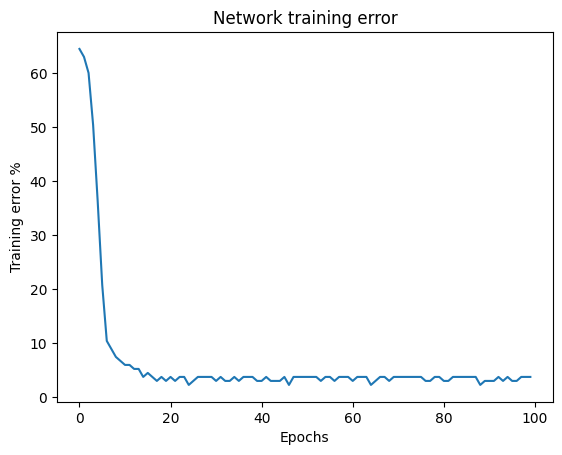

In [ ]:
x = range(0,n_epochs)
plt.plot(x, train_error_epoch, label='training error')
plt.title('Network training error')
plt.xlabel('Epochs')
plt.ylabel('Training error %')
#plt.legend(loc='best')
plt.show()

In [ ]:
test_samples = np.transpose(X_test)
test_targets = np.transpose(y_test)

y_hats = forward_pass(W1, W2, b1, b2, test_samples)[-1]
preds = np.argmax(y_hats, axis=0)
truth = np.argmax(test_targets, axis=0)
test_error = 1.*np.sum(preds!=truth)/preds.shape[0]

print(W1.shape)

print('Test error:', test_error * 100, '%')
print(preds)
print(truth)

(100, 4)
Test error: 0.0 %
[2 0 2 0 0 2 1 0 1 2 0 1 0 0]
[2 0 2 0 0 2 1 0 1 2 0 1 0 0]
